In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATACseq_250kb_bins.txt', 'data/20_80_splits/80_all_samples_normalized_CONTROLS.rds', 'data/20_80_splits/20_all_samples_normalized_CONTROLS.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt', "input_train_data_smooth" = 'data/20_80_splits/80_all_samples_normalized_CONTROLS.rds', "input_test_data_smooth" = 'data/20_80_splits/20_all_samples_normalized_CONTROLS.rds'),
    output = list('data/20_80_experiment_ATAC_predictions/80_20/all_samples_ATAC_pred_lasso_std_TRUE.rds', 'Trained_models/20_80_experiment_models/80_20/Lasso_models/lasso_std_TRUE.rds', "output_pred" = 'data/20_80_experiment_ATAC_predictions/80_20/all_samples_ATAC_pred_lasso_std_TRUE.rds', "output_model" = 'Trained_models/20_80_experiment_models/80_20/Lasso_models/lasso_std_TRUE.rds'),
    params = list(),
    wildcards = list(),
    threads = 2,
    log = list('logs/processed_notebooks/80_20/processed_all_samples_Lasso_reg_TRUE.r.ipynb', "notebook" = 'logs/processed_notebooks/80_20/processed_all_samples_Lasso_reg_TRUE.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 7034, "tmpdir" = '/scratch/56028897', "time" = '5:00:00'),
    config = list(),
    rule = 'all_samples_model_lasso_smoothing',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/20_80_experiments',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)

library(glmnet)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_CONTROLS.csv", nrows=20000)
all_samples_controls <- readRDS(snakemake@input[["input_train_data_smooth"]])
head(all_samples_controls)

,sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
1820074,PGDX18451P,chr4_469,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461702,PGDX17967P,chr6_650,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2239111,PGDX4557P,chr16_204,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
546136,PGDX17976P,chr10_468,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284572,PGDX17950P,chr3_136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
387871,PGDX17960P,chr3_391,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)

colnames(ATAC) <- c("bin", "ATAC_observed")
head(ATAC)

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_controls <- inner_join(all_samples_controls, ATAC, by="bin")

head(all_samples_ATAC_controls)

bin,ATAC_observed
chr1_0,0.05376791
chr10_0,0.29698782
chr10_1,0.40893151
chr10_10,0.30582283
chr10_100,0.59316570
chr10_101,0.47641373


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,ATAC_observed
PGDX18451P,chr4_469,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.4396274
PGDX17967P,chr6_650,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.3497848
PGDX4557P,chr16_204,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.4393724
PGDX17976P,chr10_468,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.3066738
PGDX17950P,chr3_136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.4571165
PGDX17960P,chr3_391,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.4668637


In [5]:
ATAC_val <- all_samples_ATAC_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_controls %>% select(sample, bin)
all_samples_ATAC_controls = all_samples_ATAC_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_ATAC_controls)
head(ATAC_val)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ATAC_observed
0.4396274
0.3497848
0.4393724
0.3066738
0.4571165
0.4668637


## Lasso regression

Cross validation to find the best lambda

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

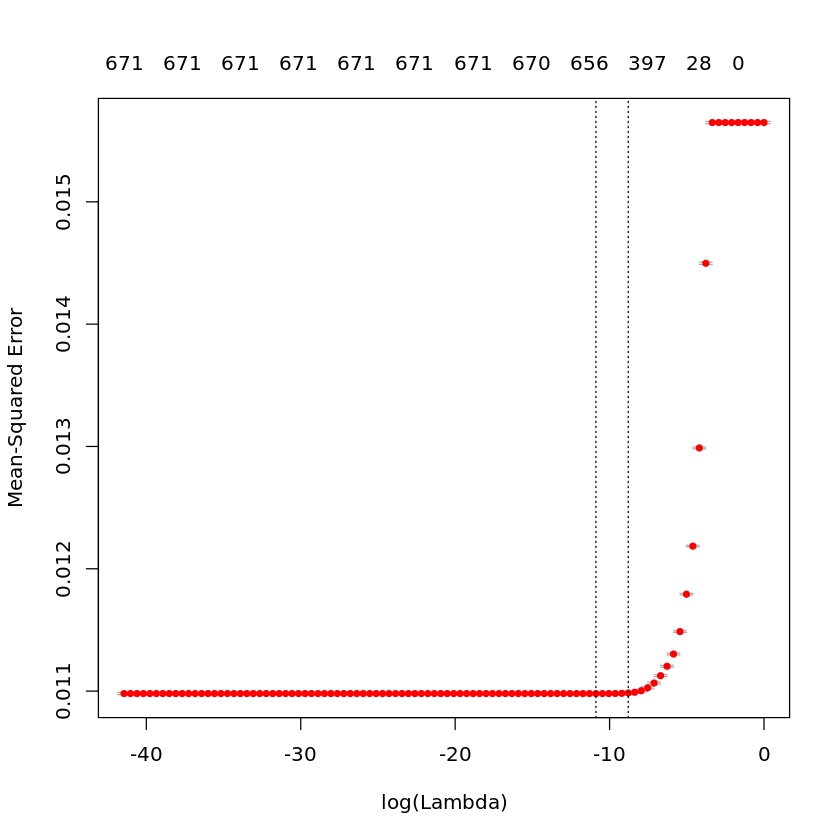

In [6]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

lambdas_to_try <- 10^seq(-18, 0, length.out = 100)
#standardize = FALSE -- range -10 to -5
#standardize = TRUE -- range -7 to -3

lasso_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_cv)

In [7]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 1.873817e-05

## Fit the model on all traindata controls

In [8]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on normalized 20% of controls using the model (fitted on train controls) and save the predictions to file

In [9]:
#filename = "../../../data/all_samples_normalized_CASES.csv"
#test_data = readRDS("../../data/20_80_splits/20_all_samples_normalized_CONTROLS.rds")

test_data = readRDS(snakemake@input[["input_test_data_smooth"]])

In [10]:
head(test_data)

,sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
2,PGDX16568P,chr10_40,0,0,0,0,0,0.0000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
9,PGDX16568P,chr10_406,0,0,0,0,0,0.0000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
17,PGDX16568P,chr10_413,0,0,0,0,0,0.0000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
26,PGDX16568P,chr10_421,0,0,0,0,0,0.0001756235,0,0,...,0,0,0,0,0,0,0,0,0,0
30,PGDX16568P,chr10_425,0,0,0,0,0,0.0000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
43,PGDX16568P,chr10_437,0,0,0,0,0,0.0000000000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [12]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

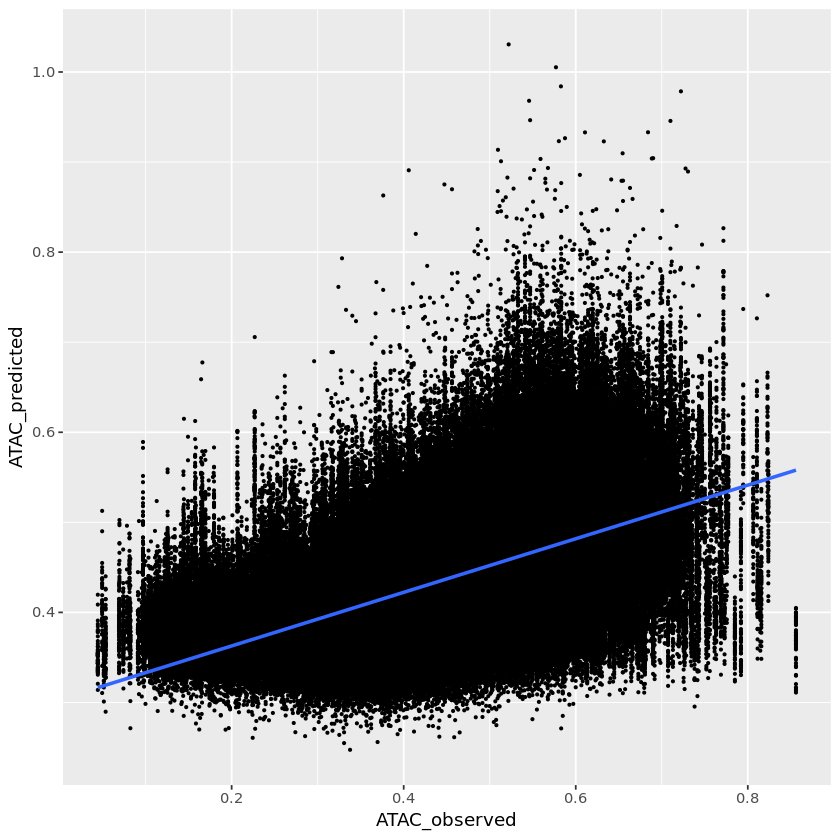

In [13]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [14]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.5451949

In [15]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08149649

In [16]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1049435

In [17]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])